COMPREHENSIVE MORPHINE FEATURE ANALYSIS

Objective: Identify ALL features showing dose-dependent morphine response
across temporal windows

Loading comprehensive feature set...
  Cages: 9
  Dates: ['2025-01-14', '2025-01-15']

1. Loading activity states...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Activity metrics: ['animal_bouts.active', 'animal_bouts.climbing', 'animal_bouts.inactive', 'animal_bouts.locomotion']
2. Loading distance metrics...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Distance metrics: ['animal.distance_travelled', 'animal.distance_travelled.raw']
3. Loading respiration metrics...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Respiration metrics: ['animal.respiration_rate_lucas_kanade_peaks', 'animal.respiration_rate_lucas_kanade_psd']
4. Loading social distance metrics...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Social metrics: ['distance_blackallwhite_browncheckered.animal.cm', 'distance_blackallwhite_noread.animal.cm', 'distance_blackallwhite_redbarred.animal.cm', 'distance_browncheckered_noread.animal.cm', 'distance_browncheckered_redbarred.animal.cm', 'distance_noread_redbarred.animal.cm']
5. Loading motion scores...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

6. Loading time series metrics...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  TSDB metrics: 12 features

Merging all feature sources...

✓ Loaded 1493082 records
✓ Total features: 27

BASELINE NORMALIZATION

ANALYZING ALL FEATURES ACROSS TIME WINDOWS
✓ Analyzed 553 feature × treatment × window combinations

DOSE-RESPONSE ANALYSIS

✓ Found 14 features with dose-response

Top dose-responsive features:
                                   feature         window  high_dose_pct  high_cohens_d dose_response_type
  animal.respiration_rate_lucas_kanade_psd      post_12hr       6.251264       4.324915         increasing
             animal.distance_travelled.raw   decline_late     273.354004       3.388599         increasing
                   animal_bouts.locomotion   decline_late    1090.796410       2.801988         increasing
                   animal_bouts.locomotion  decline_early    1614.873201       1.813708         increasing
animal.respiration_rate_lucas_kanade_peaks   decline_late       4.418825       1.755275         increasing
       distance_noread_redbarre

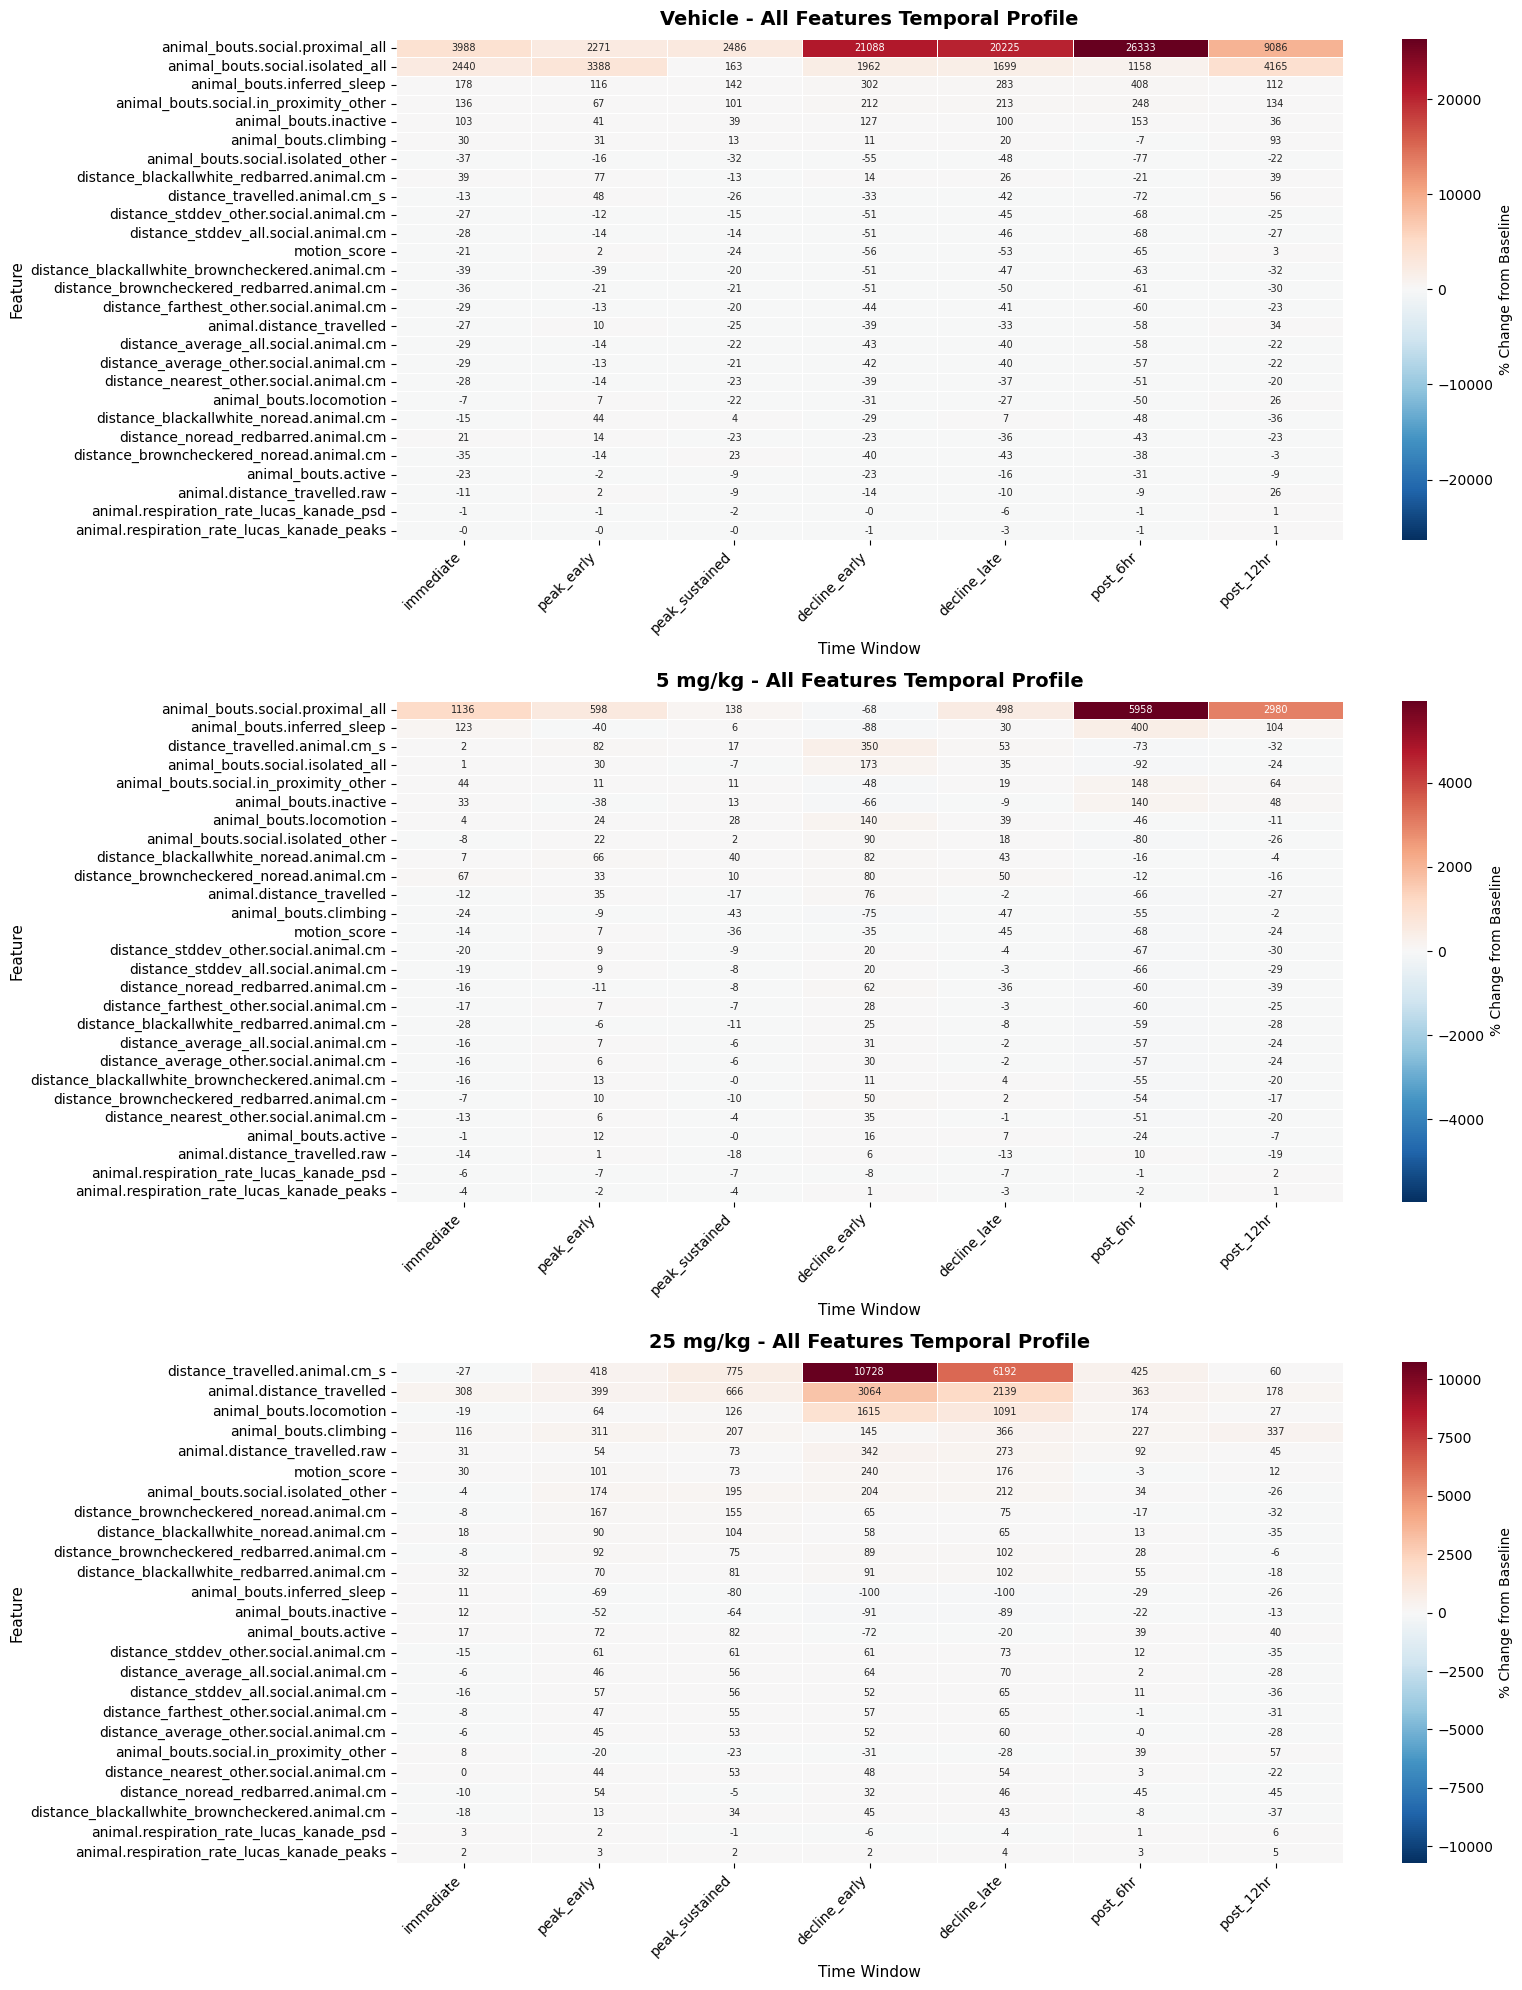


✓ Saved: comprehensive_feature_heatmap.png

SUMMARY REPORT

Total features analyzed: 27
Features with dose-response: 14

Features by category:
  Activity States: 9 total, 1 dose-responsive
  Distance/Movement: 15 total, 10 dose-responsive
  Respiration: 2 total, 2 dose-responsive
  Social: 10 total, 5 dose-responsive
  Other: 1 total, 1 dose-responsive

✓ Saved: all_features_analysis.csv
✓ Saved: dose_responsive_features.csv

NEXT STEPS FOR PRESENTATION:
1. Review dose_responsive_features.csv for features beyond locomotion
2. Check if effect directions are consistent within individuals
3. Identify novel morphine biomarkers in this dataset
4. Compare effect sizes across feature categories


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
TREATMENT_MAP = {
    4917: '5 mg/kg', 4918: 'Vehicle', 4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg', 4922: 'Vehicle',
    4923: 'Vehicle', 4924: '25 mg/kg', 4925: '5 mg/kg'
}

INJECTION_DATETIME = datetime(2025, 1, 14, 6, 0, 0)

# Time windows (adjusted for cage-level data)
TIME_WINDOWS = {
    'baseline': (-30, 0),
    'immediate': (0, 120),
    'peak_early': (120, 240),
    'peak_sustained': (240, 360),
    'decline_early': (360, 480),
    'decline_late': (480, 600),
    'post_6hr': (600, 900),
    'post_12hr': (900, 1200),
}

print("="*80)
print("COMPREHENSIVE MORPHINE FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Identify ALL features showing dose-dependent morphine response")
print("across temporal windows\n")

# Initialize DuckDB
con = duckdb.connect()
con.execute("SET s3_region='us-east-1';")
con.execute("SET s3_url_style='path';")

def generate_paths(cages, dates, filename):
    paths = []
    for cage in cages:
        for date in dates:
            path = f"s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id={cage}/date={date}/{filename}"
            paths.append(f"'{path}'")
    return ', '.join(paths)

# Load data from injection day + next day
dates = [(INJECTION_DATETIME + timedelta(days=d)).strftime('%Y-%m-%d') 
         for d in range(0, 2)]
cages = list(TREATMENT_MAP.keys())

print(f"Loading comprehensive feature set...")
print(f"  Cages: {len(cages)}")
print(f"  Dates: {dates}")

# ============================================================================
# LOAD ALL AVAILABLE FEATURES
# ============================================================================

all_features = {}

# 1. Activity states
print("\n1. Loading activity states...")
activity_paths = generate_paths(cages, dates, 'animal_activity_db.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    value
FROM read_parquet([{activity_paths}])
WHERE resolution = 60
"""
df_activity = con.execute(query).df()
df_activity['time'] = pd.to_datetime(df_activity['time'])
df_activity['minutes_from_injection'] = (df_activity['time'] - INJECTION_DATETIME).dt.total_seconds() / 60

activity_pivot = df_activity.pivot_table(
    index=['cage_id', 'minutes_from_injection'],
    columns='name',
    values='value',
    aggfunc='mean'
).reset_index()
activity_pivot.columns.name = None

print(f"  Activity metrics: {[c for c in activity_pivot.columns if 'animal' in c]}")

# 2. Distance metrics
print("2. Loading distance metrics...")
distance_paths = generate_paths(cages, dates, 'animal_aggs_short_id.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    AVG(value) as value
FROM read_parquet([{distance_paths}])
WHERE resolution = 60
GROUP BY cage_id, time, name
"""
df_distance = con.execute(query).df()
df_distance['time'] = pd.to_datetime(df_distance['time'])
df_distance['minutes_from_injection'] = (df_distance['time'] - INJECTION_DATETIME).dt.total_seconds() / 60

distance_pivot = df_distance.pivot_table(
    index=['cage_id', 'minutes_from_injection'],
    columns='name',
    values='value',
    aggfunc='mean'
).reset_index()
distance_pivot.columns.name = None

print(f"  Distance metrics: {[c for c in distance_pivot.columns if 'distance' in c or 'animal' in c]}")

# 3. Respiration
print("3. Loading respiration metrics...")
resp_paths = generate_paths(cages, dates, 'animal_respiration.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    AVG(value) as value
FROM read_parquet([{resp_paths}])
GROUP BY cage_id, time, name
"""
df_resp = con.execute(query).df()
df_resp['time'] = pd.to_datetime(df_resp['time'])
df_resp['minutes_from_injection'] = (df_resp['time'] - INJECTION_DATETIME).dt.total_seconds() / 60

resp_pivot = df_resp.pivot_table(
    index=['cage_id', 'minutes_from_injection'],
    columns='name',
    values='value',
    aggfunc='mean'
).reset_index()
resp_pivot.columns.name = None

print(f"  Respiration metrics: {[c for c in resp_pivot.columns if 'respiration' in c]}")

# 4. Social distance
print("4. Loading social distance metrics...")
social_paths = generate_paths(cages, dates, 'animal_sociability_pairwise.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    AVG(value) as value
FROM read_parquet([{social_paths}])
GROUP BY cage_id, time, name
"""
df_social = con.execute(query).df()
df_social['time'] = pd.to_datetime(df_social['time'])
df_social['minutes_from_injection'] = (df_social['time'] - INJECTION_DATETIME).dt.total_seconds() / 60

social_pivot = df_social.pivot_table(
    index=['cage_id', 'minutes_from_injection'],
    columns='name',
    values='value',
    aggfunc='mean'
).reset_index()
social_pivot.columns.name = None

print(f"  Social metrics: {[c for c in social_pivot.columns if 'distance' in c]}")

# 5. Motion scores
print("5. Loading motion scores...")
motion_paths = generate_paths(cages, dates, 'cage_motion_vector.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    AVG(value) as motion_score
FROM read_parquet([{motion_paths}])
WHERE resolution = 60
GROUP BY cage_id, time
"""
df_motion = con.execute(query).df()
df_motion['time'] = pd.to_datetime(df_motion['time'])
df_motion['minutes_from_injection'] = (df_motion['time'] - INJECTION_DATETIME).dt.total_seconds() / 60

# 6. Time series database (additional metrics)
print("6. Loading time series metrics...")
tsdb_paths = generate_paths(cages, dates, 'animal_tsdb_mvp.parquet')
query = f"""
SELECT 
    cage_id,
    time,
    name,
    AVG(value) as value
FROM read_parquet([{tsdb_paths}])
WHERE resolution = 60
GROUP BY cage_id, time, name
"""
df_tsdb = con.execute(query).df()
df_tsdb['time'] = pd.to_datetime(df_tsdb['time'])
df_tsdb['minutes_from_injection'] = (df_tsdb['time'] - INJECTION_DATETIME).dt.total_seconds() / 60

tsdb_pivot = df_tsdb.pivot_table(
    index=['cage_id', 'minutes_from_injection'],
    columns='name',
    values='value',
    aggfunc='mean'
).reset_index()
tsdb_pivot.columns.name = None

print(f"  TSDB metrics: {len([c for c in tsdb_pivot.columns if c not in ['cage_id', 'minutes_from_injection']])} features")

# Merge all features
print("\nMerging all feature sources...")
df = activity_pivot.copy()
df = df.merge(distance_pivot, on=['cage_id', 'minutes_from_injection'], how='outer')
df = df.merge(resp_pivot, on=['cage_id', 'minutes_from_injection'], how='outer')
df = df.merge(social_pivot, on=['cage_id', 'minutes_from_injection'], how='outer')
df = df.merge(df_motion, on=['cage_id', 'minutes_from_injection'], how='outer')
df = df.merge(tsdb_pivot, on=['cage_id', 'minutes_from_injection'], how='outer')

df['treatment'] = df['cage_id'].map(TREATMENT_MAP)

# Get numeric feature columns
feature_cols = [c for c in df.columns 
                if c not in ['cage_id', 'minutes_from_injection', 'treatment'] 
                and df[c].dtype in ['float64', 'float32', 'int64', 'int32']]

print(f"\n✓ Loaded {len(df)} records")
print(f"✓ Total features: {len(feature_cols)}")

# ============================================================================
# BASELINE NORMALIZATION
# ============================================================================
print("\n" + "="*80)
print("BASELINE NORMALIZATION")
print("="*80)

baseline_window = TIME_WINDOWS['baseline']
baseline_data = df[
    (df['minutes_from_injection'] >= baseline_window[0]) & 
    (df['minutes_from_injection'] < baseline_window[1])
]

cage_baselines = {}
for feature in feature_cols:
    cage_baselines[feature] = baseline_data.groupby('cage_id')[feature].mean()

# Normalize
for feature in feature_cols:
    df[f'{feature}_baseline'] = df['cage_id'].map(cage_baselines[feature])
    df[f'{feature}_fold_change'] = df[feature] / df[f'{feature}_baseline']

# ============================================================================
# CALCULATE EFFECTS FOR ALL FEATURES
# ============================================================================
print("\n" + "="*80)
print("ANALYZING ALL FEATURES ACROSS TIME WINDOWS")
print("="*80)

results = []

for window_name, (start, end) in TIME_WINDOWS.items():
    if window_name == 'baseline':
        continue
    
    window_data = df[
        (df['minutes_from_injection'] >= start) & 
        (df['minutes_from_injection'] < end)
    ]
    
    for treatment in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        for feature in feature_cols:
            # Get cage-level fold changes
            cage_fc = window_data[window_data['treatment'] == treatment].groupby('cage_id')[f'{feature}_fold_change'].mean()
            
            if len(cage_fc) < 2:
                continue
            
            # Remove NaN/inf values
            cage_fc = cage_fc[np.isfinite(cage_fc)]
            
            if len(cage_fc) < 2:
                continue
            
            # Calculate statistics
            mean_fc = cage_fc.mean()
            std_fc = cage_fc.std()
            n = len(cage_fc)
            
            # Calculate percent change
            pct_change = (mean_fc - 1) * 100
            
            # Calculate Cohen's d (comparing to 1.0 = no change)
            if std_fc > 0:
                cohens_d = (mean_fc - 1) / std_fc
            else:
                cohens_d = 0
            
            results.append({
                'window': window_name,
                'treatment': treatment,
                'feature': feature,
                'n_cages': n,
                'mean_fold_change': mean_fc,
                'pct_change': pct_change,
                'std': std_fc,
                'cohens_d': cohens_d,
                'abs_cohens_d': abs(cohens_d)
            })

results_df = pd.DataFrame(results)

print(f"✓ Analyzed {len(results_df)} feature × treatment × window combinations")

# ============================================================================
# IDENTIFY DOSE-RESPONSIVE FEATURES
# ============================================================================
print("\n" + "="*80)
print("DOSE-RESPONSE ANALYSIS")
print("="*80)

# For each feature and window, check if there's dose-response relationship
dose_response_features = []

for window_name in [w for w in TIME_WINDOWS.keys() if w != 'baseline']:
    window_results = results_df[results_df['window'] == window_name]
    
    for feature in feature_cols:
        feature_results = window_results[window_results['feature'] == feature]
        
        if len(feature_results) < 3:
            continue
        
        # Get mean effects for each dose
        vehicle_effect = feature_results[feature_results['treatment'] == 'Vehicle']['pct_change'].values
        low_effect = feature_results[feature_results['treatment'] == '5 mg/kg']['pct_change'].values
        high_effect = feature_results[feature_results['treatment'] == '25 mg/kg']['pct_change'].values
        
        if len(vehicle_effect) == 0 or len(low_effect) == 0 or len(high_effect) == 0:
            continue
        
        vehicle_effect = vehicle_effect[0]
        low_effect = low_effect[0]
        high_effect = high_effect[0]
        
        # Check for monotonic dose-response
        is_increasing = (abs(high_effect) > abs(low_effect) > abs(vehicle_effect))
        is_decreasing = (abs(high_effect) < abs(low_effect) < abs(vehicle_effect))
        
        # Get effect sizes
        high_cohens_d = feature_results[feature_results['treatment'] == '25 mg/kg']['cohens_d'].values[0]
        
        # Criteria for dose-responsive feature:
        # 1. High dose shows |Cohen's d| > 1.0 (large effect)
        # 2. Dose-response relationship exists
        # 3. High dose effect is at least 2x vehicle effect
        
        if abs(high_cohens_d) > 1.0 and (is_increasing or is_decreasing):
            dose_response_features.append({
                'feature': feature,
                'window': window_name,
                'vehicle_pct': vehicle_effect,
                'low_dose_pct': low_effect,
                'high_dose_pct': high_effect,
                'high_cohens_d': high_cohens_d,
                'dose_response_type': 'increasing' if is_increasing else 'decreasing'
            })

dose_response_df = pd.DataFrame(dose_response_features)

if len(dose_response_df) > 0:
    print(f"\n✓ Found {len(dose_response_df['feature'].unique())} features with dose-response")
    print(f"\nTop dose-responsive features:")
    # Add absolute value column
    dose_response_df['abs_high_cohens_d'] = dose_response_df['high_cohens_d'].abs()
    top_features = dose_response_df.sort_values('abs_high_cohens_d', ascending=False).head(20)
    print(top_features[['feature', 'window', 'high_dose_pct', 'high_cohens_d', 'dose_response_type']].to_string(index=False))

# ============================================================================
# CREATE COMPREHENSIVE HEATMAP
# ============================================================================
print("\n" + "="*80)
print("CREATING COMPREHENSIVE FEATURE HEATMAP")
print("="*80)

# Filter to most responsive features across all windows
feature_max_effects = results_df.groupby('feature')['abs_cohens_d'].max().sort_values(ascending=False)
top_features = feature_max_effects.head(30).index.tolist()

print(f"\nPlotting top {len(top_features)} features by maximum effect size")

# Create heatmap for each treatment
fig, axes = plt.subplots(3, 1, figsize=(16, 20))

window_order = ['immediate', 'peak_early', 'peak_sustained', 'decline_early', 
                'decline_late', 'post_6hr', 'post_12hr']

for idx, treatment in enumerate(['Vehicle', '5 mg/kg', '25 mg/kg']):
    treatment_data = results_df[
        (results_df['treatment'] == treatment) &
        (results_df['feature'].isin(top_features))
    ]
    
    if len(treatment_data) == 0:
        continue
    
    # Create pivot
    pivot = treatment_data.pivot_table(
        index='feature',
        columns='window',
        values='pct_change',
        aggfunc='mean'
    )
    
    # Reorder columns
    pivot = pivot[[col for col in window_order if col in pivot.columns]]
    
    # Sort by maximum absolute effect
    feature_importance = pivot.abs().max(axis=1).sort_values(ascending=False)
    pivot = pivot.loc[feature_importance.index]
    
    # Dynamic color scale
    vmax = max(50, pivot.abs().max().max())
    
    # Plot
    ax = axes[idx]
    sns.heatmap(pivot,
               ax=ax,
               cmap='RdBu_r',
               center=0,
               vmin=-vmax, vmax=vmax,
               cbar_kws={'label': '% Change from Baseline'},
               linewidths=0.5,
               annot=True,
               fmt='.0f',
               annot_kws={'size': 7})
    
    ax.set_title(f'{treatment} - All Features Temporal Profile', 
                fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Time Window', fontsize=11)
    ax.set_ylabel('Feature', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('comprehensive_feature_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: comprehensive_feature_heatmap.png")

# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("SUMMARY REPORT")
print("="*80)

print(f"\nTotal features analyzed: {len(feature_cols)}")
print(f"Features with dose-response: {len(dose_response_df['feature'].unique())}")
print(f"\nFeatures by category:")

# Categorize features
categories = {
    'Activity States': [f for f in feature_cols if 'bouts' in f],
    'Distance/Movement': [f for f in feature_cols if 'distance' in f.lower()],
    'Respiration': [f for f in feature_cols if 'respiration' in f.lower()],
    'Social': [f for f in feature_cols if 'social' in f.lower() or any(x in f for x in ['mean_all', 'mean_other', 'nearest'])],
    'Other': [f for f in feature_cols if not any(cat in f.lower() for cat in ['bout', 'distance', 'respiration', 'social', 'mean_', 'nearest'])]
}

for category, features in categories.items():
    if len(features) > 0:
        responsive = [f for f in features if f in dose_response_df['feature'].unique()]
        print(f"  {category}: {len(features)} total, {len(responsive)} dose-responsive")

# Save results
results_df.to_csv('all_features_analysis.csv', index=False)
if len(dose_response_df) > 0:
    dose_response_df.to_csv('dose_responsive_features.csv', index=False)

print("\n✓ Saved: all_features_analysis.csv")
print("✓ Saved: dose_responsive_features.csv")

print("\n" + "="*80)
print("NEXT STEPS FOR PRESENTATION:")
print("="*80)
print("1. Review dose_responsive_features.csv for features beyond locomotion")
print("2. Check if effect directions are consistent within individuals")
print("3. Identify novel morphine biomarkers in this dataset")
print("4. Compare effect sizes across feature categories")
print("="*80)

con.close()